In [111]:
import math
import time

import numba
import numpy as np
import matplotlib.pyplot as plt
import scipy

from numba import njit, prange
from stumpy import core

## The [OTFFT](http://wwwa.pikara.ne.jp/okojisan/otfft-en/stockham2.html) algorithm

We will implement the `OTFFT` algorith, and we will try to enhance its performance. Our reference algorithm is `stumpy.core.sliding_dot_product`, which uses `scipy.fft.convolve`. Each new version is built on top of the previous version, i.e. all previously-implement enhancemants are included.

We use time series `T` with length $2^{15}$, and the query of different lengths in `range(10, 1000+10, 10)`.

In [112]:
def plot_performance(comp_func, ref_func=core.sliding_dot_product, test_output=False):
    """
    Plot the performance of `ref_func` and `comp_func`. 
    As a bonus, it tests their performance too when `test_output` is set to True.
    """
    n_power = 15
    n = 2 ** n_power
    m_values = range(10, 1000 + 10, 10)
    
    m_values_labels = np.arange(0, 1000 + 100, 100)
    m_values_labels[0] = 10
    m_values_ticks = np.flatnonzero(np.isin(m_values, m_values_labels))
    
    seed = 0
    np.random.seed(seed)

    T = np.random.rand(n)

    running_time = np.zeros((len(m_values), 2)) 
    for i, m in enumerate(m_values):
        Q = T[:m]

        # ref
        t1 = time.time()
        ref = ref_func(Q, T)
        t2 = time.time()
        running_time[i, 0] = t2 - t1

        # comp
        t1 = time.time()
        comp = comp_func(Q, T)
        t2 = time.time()
        running_time[i, 1] = t2 - t1
        
        if test_output:
            np.testing.assert_almost_equal(ref, comp)

            
    plt.figure(figsize=(20, 5))
    plt.title(f"The log2 of length of `T` is: {n_power}", fontsize=13)
    plt.plot(running_time[:, 0], label='ref')
    plt.plot(running_time[:, 1], label='comp')
    
    plt.xticks(ticks=m_values_ticks, labels=m_values_labels, fontsize=13)
    plt.yticks(fontsize=13)
    
    plt.xlabel('The length of query, `Q`', fontsize=13)
    plt.ylabel('running time', fontsize=13)
    plt.legend()
    plt.show()

### version 0

In [113]:
def _list7_fft_v0(n, s, eo, x, y):
    m = n // 2
    theta0 = 2 * math.pi / n
    if n == 1:
        if eo:
            for q in range(s):
                y[q] = x[q]
    else:
        for p in range(m):
            wp = complex(math.cos(p*theta0), -math.sin(p*theta0))
            for q in range(s):
                a = complex(x[q + s*(p + 0)])
                b = complex(x[q + s*(p + m)])
                y[q + s*(2*p + 0)] = a + b
                y[q + s*(2*p + 1)] = (a - b) * wp
        _list7_fft_v0(n//2, 2*s, not eo, y, x)


# I swapped the params of `fft` function to make its signature similar to `scipy.ftt.ftt`
def list7_fft_v0(x):
    n = len(x)
    y = np.empty(n, dtype=complex)
    _list7_fft_v0(n, 1, False, x, y)
    
    

def list7_ifft_v0(x):
    """
    where x is the fft result
    """
    n = len(x) 
    x = np.conjugate(x)
    y = np.empty(n, dtype=np.complex128)
    _list7_fft_v0(n, 1, False, x, y)
    
    return np.conjugate(x / n)


def _list7_sliding_dot_product_v0(Q, T):
    n = len(T)
    m = len(Q)
    
    x = T.astype(complex)
    Qr = np.zeros(n, dtype=complex)
    Qr[:m] = np.flipud(Q)
    
    list7_fft_v0(x)
    list7_fft_v0(Qr)
    Qr[:] = list7_ifft_v0(x * Qr)
    
    return Qr.real[m-1:]


def sliding_dot_product_v0(Q, T):
    return _list7_sliding_dot_product_v0(Q, T)

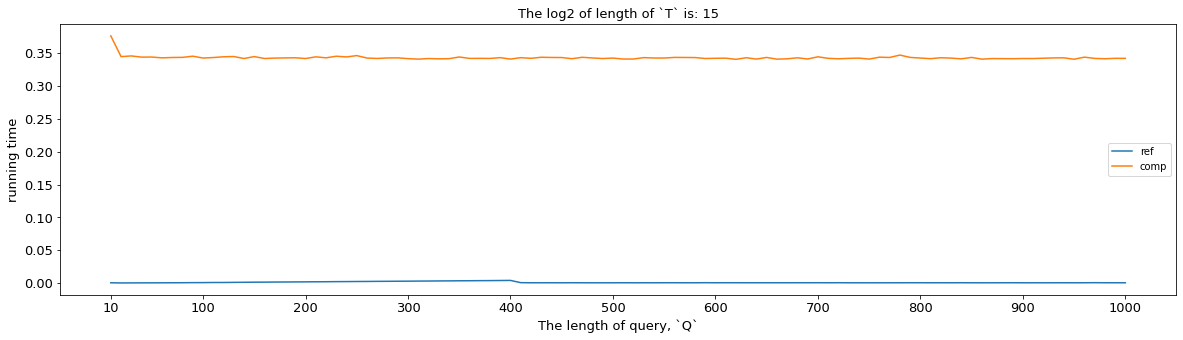

In [115]:
# check performance
comp = sliding_dot_product_v0
plot_performance(
    comp, 
    ref_func=core.sliding_dot_product, 
    test_output=True
)

### version 1
**Enhancement:** created the array `y` once, and reused it.

In [73]:
# let's improve the function
def _list7_fft_v1(n, s, eo, x, y):
    m = n // 2
    theta0 = 2 * math.pi / n
    if n == 1:
        if eo:
            for q in range(s):
                y[q] = x[q]
    else:
        for p in range(m):
            wp = complex(math.cos(p*theta0), -math.sin(p*theta0))
            for q in range(s):
                a = complex(x[q + s*(p + 0)])
                b = complex(x[q + s*(p + m)])
                y[q + s*(2*p + 0)] = a + b
                y[q + s*(2*p + 1)] = (a - b) * wp
        _list7_fft_v1(n//2, 2*s, not eo, y, x)


# I swapped the params of `fft` function to make its signature similar to `scipy.ftt.ftt`
def list7_fft_v1(x):
    n = len(x)
    y = np.empty(n, dtype=complex)
    _list7_fft_v1(n, 1, False, x, y)
    

    
def _list7_ifft_v1(n, x, y):
    x[:] = np.conjugate(x)
    _list7_fft_v1(n, 1, False, x, y)
    x[:] = np.conjugate(x / n)

def list7_ifft_v1(x):
    """
    where x is the fft result
    """
    n = len(x) 
    _list7_ifft_v1(n, x, y)

def _list7_sliding_dot_product_v1(Q, T):
    n = len(T)
    m = len(Q)
    
    x = T.astype(complex)
    y = np.empty(n, dtype=complex)
    Qr = np.zeros(n, dtype=complex)
    Qr[:m] = np.flipud(Q)
    
    _list7_fft_v1(n, 1, False, x, y)
    _list7_fft_v1(n, 1, False, Qr, y)
    
    Qr[:] = Qr * x
    _list7_ifft_v1(n, Qr, y)
        
    return Qr.real[m-1:]


def sliding_dot_product_v1(Q, T):
    return _list7_sliding_dot_product_v1(Q, T)

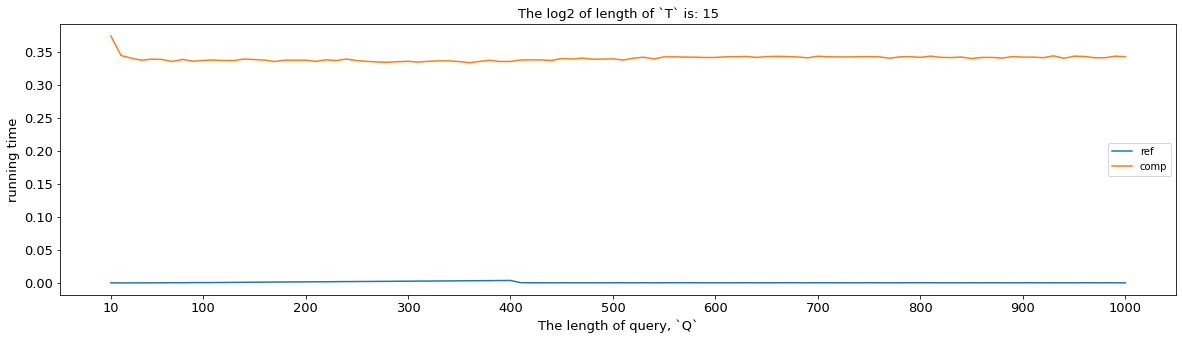

In [116]:
# check performance
comp = sliding_dot_product_v1
plot_performance(
    comp, 
    ref_func=core.sliding_dot_product, 
    test_output=True
)

### version 2
**Enhancement:** Converted the inner for-loop to a numpy vectorized operation

In [117]:
# let's improve the function
def _list7_fft_v2(n, s, eo, x, y):
    m = n // 2
    theta0 = 2 * math.pi / n
    if n == 1:
        if eo:
            y[:s] = x[:s]
            """for q in range(s):
                y[q] = x[q]"""
    else:
        sm = s * m
        for p in range(m):
            wp = complex(math.cos(p*theta0), -math.sin(p*theta0))
            sp = s * p
            a_start = sp
            b_start = sp + sm
            # a_start = s * (p + 0)
            # b_start = s * (p + m)
            
            idx = 2 * sp
            y[idx : idx + s] = x[a_start:a_start + s] + x[b_start : b_start + s]
            y[idx + s : idx + 2 * s] = (x[a_start:a_start + s] - x[b_start : b_start + s]) * wp
            """for q in range(s):
                a = x[q + s * (p + 0)]
                b = x[q + s * (p + m)]
                y[q + s * (2 * p + 0)] = a + b
                y[q + s * (2 * p + 1)] = (a - b) * wp"""

        _list7_fft_v2(n//2, 2*s, not eo, y, x)


# I swapped the params of `fft` function to make its signature similar to `scipy.ftt.ftt`
def list7_fft_v2(x):
    n = len(x)
    y = np.empty(n, dtype=complex)
    _list7_fft_v2(n, 1, False, x, y)
    

    
def _list7_ifft_v2(n, x, y):
    x[:] = np.conjugate(x)
    _list7_fft_v2(n, 1, False, x, y)
    x[:] = np.conjugate(x / n)

def list7_ifft_v2(x):
    """
    where x is the fft result
    """
    n = len(x) 
    _list7_ifft_v2(n, x, y)

def _list7_sliding_dot_product_v2(Q, T):
    n = len(T)
    m = len(Q)
    
    x = T.astype(complex)
    y = np.empty(n, dtype=complex)
    Qr = np.zeros(n, dtype=complex)
    Qr[:m] = np.flipud(Q)
    
    _list7_fft_v2(n, 1, False, x, y)
    _list7_fft_v2(n, 1, False, Qr, y)
    
    Qr[:] = Qr * x
    _list7_ifft_v2(n, Qr, y)
        
    return Qr.real[m-1:]


def sliding_dot_product_v2(Q, T):
    return _list7_sliding_dot_product_v2(Q, T)

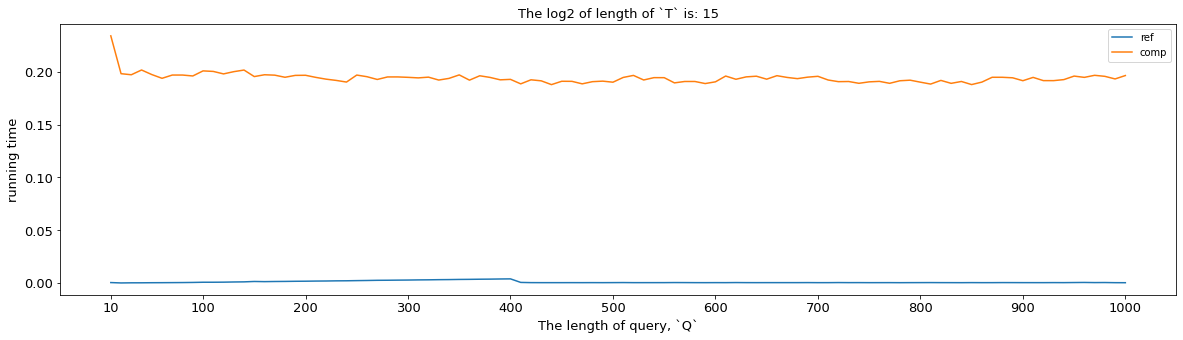

In [118]:
# check performance
comp = sliding_dot_product_v2
plot_performance(
    comp, 
    ref_func=core.sliding_dot_product, 
    test_output=True
)

### version 3
**Enhancement:** Added the numba `njit` decorator with `fastmath=True`.

In [119]:
# let's improve the function
@njit(fastmath=True)
def _list7_fft_v3(n, s, eo, x, y):
    m = n // 2
    theta0 = 2 * math.pi / n
    if n == 1:
        if eo:
            y[:s] = x[:s]
            """for q in range(s):
                y[q] = x[q]"""
    else:
        sm = s * m
        for p in range(m):
            wp = complex(math.cos(p*theta0), -math.sin(p*theta0))
            sp = s * p
            a_start = sp
            b_start = sp + sm
            # a_start = s * (p + 0)
            # b_start = s * (p + m)
            
            idx = 2 * sp
            y[idx : idx + s] = x[a_start:a_start + s] + x[b_start : b_start + s]
            y[idx + s : idx + 2 * s] = (x[a_start:a_start + s] - x[b_start : b_start + s]) * wp
            """for q in range(s):
                a = x[q + s * (p + 0)]
                b = x[q + s * (p + m)]
                y[q + s * (2 * p + 0)] = a + b
                y[q + s * (2 * p + 1)] = (a - b) * wp"""

        _list7_fft_v3(n//2, 2*s, not eo, y, x)


# I swapped the params of `fft` function to make its signature similar to `scipy.ftt.ftt`
def list7_fft_v3(x):
    n = len(x)
    y = np.empty(n, dtype=np.complex128)
    _list7_fft_v3(n, 1, False, x, y)
    

@njit(fastmath=True)
def _list7_ifft_v3(n, x, y):
    x[:] = np.conjugate(x)
    _list7_fft_v3(n, 1, False, x, y)
    x[:] = np.conjugate(x / n)

def list7_ifft_v3(x):
    """
    where x is the fft result
    """
    n = len(x) 
    _list7_ifft_v3(n, x, y)

@njit(fastmath=True)
def _list7_sliding_dot_product_v3(Q, T):
    n = len(T)
    m = len(Q)
    
    x = T.astype(np.complex128)
    y = np.empty(n, dtype=np.complex128)
    Qr = np.zeros(n, dtype=np.complex128)
    Qr[:m] = np.flipud(Q)
    
    _list7_fft_v3(n, 1, False, x, y)
    _list7_fft_v3(n, 1, False, Qr, y)
    
    Qr[:] = Qr * x
    _list7_ifft_v3(n, Qr, y)
        
    return Qr.real[m-1:]


def sliding_dot_product_v3(Q, T):
    return _list7_sliding_dot_product_v3(Q, T)

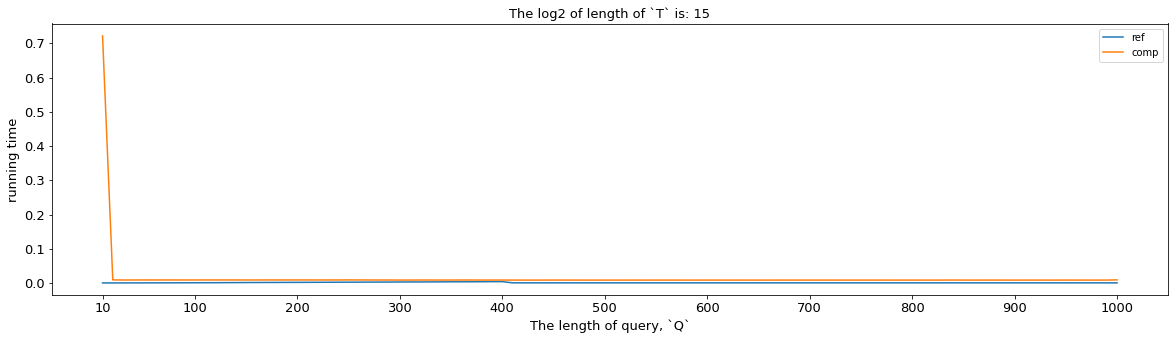

In [120]:
# check performance
comp = sliding_dot_product_v3
plot_performance(
    comp, 
    ref_func=core.sliding_dot_product, 
    test_output=True
)

### version 4
**Enhancement:** Parallelized the outer for-loop using numba `prange`

In [121]:
# let's improve the function
@njit(fastmath=True, parallel=True)
def _list7_fft_v4(n, s, eo, x, y):
    m = n // 2
    theta0 = 2 * math.pi / n
    if n == 1:
        if eo:
            y[:s] = x[:s]
            """for q in range(s):
                y[q] = x[q]"""
    else:
        sm = s * m
        for p in prange(m):
            wp = complex(math.cos(p*theta0), -math.sin(p*theta0))
            sp = s * p
            a_start = sp
            b_start = sp + sm
            # a_start = s * (p + 0)
            # b_start = s * (p + m)
            
            idx = 2 * sp
            y[idx : idx + s] = x[a_start:a_start + s] + x[b_start : b_start + s]
            y[idx + s : idx + 2 * s] = (x[a_start:a_start + s] - x[b_start : b_start + s]) * wp
            """for q in range(s):
                a = x[q + s * (p + 0)]
                b = x[q + s * (p + m)]
                y[q + s * (2 * p + 0)] = a + b
                y[q + s * (2 * p + 1)] = (a - b) * wp"""

        _list7_fft_v4(n//2, 2*s, not eo, y, x)


# I swapped the params of `fft` function to make its signature similar to `scipy.ftt.ftt`
def list7_fft_v4(x):
    n = len(x)
    y = np.empty(n, dtype=np.complex128)
    _list7_fft_v4(n, 1, False, x, y)
    

@njit(fastmath=True)
def _list7_ifft_v4(n, x, y):
    x[:] = np.conjugate(x)
    _list7_fft_v4(n, 1, False, x, y)
    x[:] = np.conjugate(x / n)

def list7_ifft_v4(x):
    """
    where x is the fft result
    """
    n = len(x) 
    _list7_ifft_v4(n, x, y)

@njit(fastmath=True)
def _list7_sliding_dot_product_v4(Q, T):
    n = len(T)
    m = len(Q)
    
    x = T.astype(np.complex128)
    y = np.empty(n, dtype=np.complex128)
    Qr = np.zeros(n, dtype=np.complex128)
    Qr[:m] = np.flipud(Q)
    
    _list7_fft_v4(n, 1, False, x, y)
    _list7_fft_v4(n, 1, False, Qr, y)
    
    Qr[:] = Qr * x
    _list7_ifft_v4(n, Qr, y)
        
    return Qr.real[m-1:]


def sliding_dot_product_v4(Q, T):
    return _list7_sliding_dot_product_v4(Q, T)

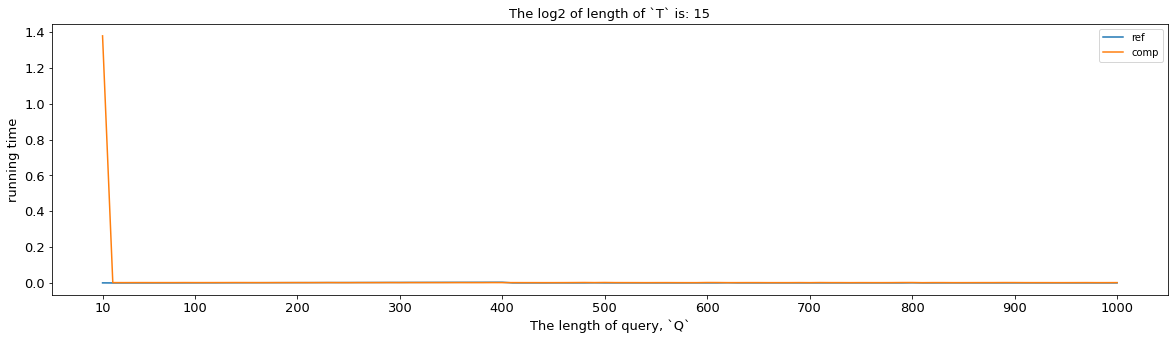

In [122]:
# check performance
comp = sliding_dot_product_v4
plot_performance(
    comp, 
    ref_func=core.sliding_dot_product, 
    test_output=True
)

## let's compare the four version

In [123]:
ref_func = core.sliding_dot_product

comp_func_v0 = sliding_dot_product_v0
comp_func_v1 = sliding_dot_product_v1
comp_func_v2 = sliding_dot_product_v2
comp_func_v3 = sliding_dot_product_v3
comp_func_v4 = sliding_dot_product_v4

seed = 0
np.random.seed(seed)

T = np.random.rand(n)

running_time = np.zeros((len(m_values), 6)) 
for i, m in enumerate(m_values):
    Q = T[:m]
    
    # ref
    t1 = time.time()
    ref = ref_func(Q, T)
    t2 = time.time()
    running_time[i, 0] = t2 - t1
    
    # comp_v0
    t1 = time.time()
    ref = comp_func_v0(Q, T)
    t2 = time.time()
    running_time[i, 1] = t2 - t1
    
    # comp_v1
    t1 = time.time()
    comp = comp_func_v1(Q, T)
    t2 = time.time()
    running_time[i, 2] = t2 - t1
    
    # comp_v2
    t1 = time.time()
    comp = comp_func_v2(Q, T)
    t2 = time.time()
    running_time[i, 3] = t2 - t1
    
    # comp_v3
    t1 = time.time()
    comp = comp_func_v3(Q, T)
    t2 = time.time()
    running_time[i, 4] = t2 - t1
    
    # comp_v4
    t1 = time.time()
    comp = comp_func_v4(Q, T)
    t2 = time.time()
    running_time[i, 5] = t2 - t1

In [124]:
m_values_labels = np.arange(0, 1000 + 100, 100)
m_values_labels[0] = 10

m_values_ticks = np.flatnonzero(np.isin(m_values, m_values_labels))

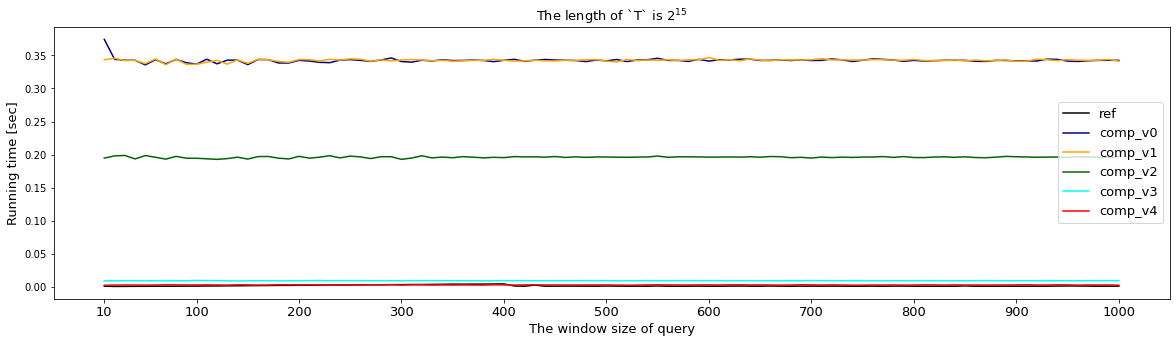

In [125]:
plt.figure(figsize=(20, 5))
plt.title('The length of `T` is $2^{15}$', fontsize=13)
plt.plot(running_time[:, 0], color='k', label='ref')
plt.plot(running_time[:, 1], color='darkblue', label='comp_v0')
plt.plot(running_time[:, 2], color='orange', label='comp_v1')
plt.plot(running_time[:, 3], color='darkgreen', label='comp_v2')
plt.plot(running_time[:, 4], color='cyan', label='comp_v3')
plt.plot(running_time[:, 5], color='r', label='comp_v4')

plt.xticks(ticks=m_values_ticks, labels=m_values_labels, fontsize=13)
plt.xlabel('The window size of query', fontsize=13)
plt.ylabel('Running time [sec]', fontsize=13)

plt.legend(ncols=1, fontsize=13)
plt.show()

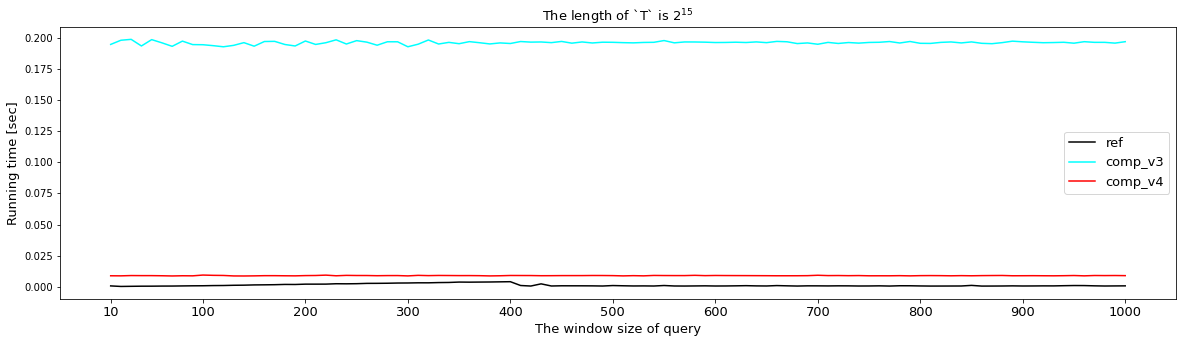

In [126]:
plt.figure(figsize=(20, 5))
plt.title('The length of `T` is $2^{15}$', fontsize=13)

plt.plot(running_time[:, 0], color='k', label='ref')
#plt.plot(running_time[:, 1], color='orange', label='comp_v1')
#plt.plot(running_time[:, 2], color='darkgreen', label='comp_v2')
plt.plot(running_time[:, 3], color='cyan', label='comp_v3')
plt.plot(running_time[:, 4], color='r', label='comp_v4')

plt.xticks(ticks=IDX, labels=m_values_label, fontsize=13)
plt.xlabel('The window size of query', fontsize=13)
plt.ylabel('Running time [sec]', fontsize=13)

plt.legend(ncols=1, fontsize=13)
plt.show()

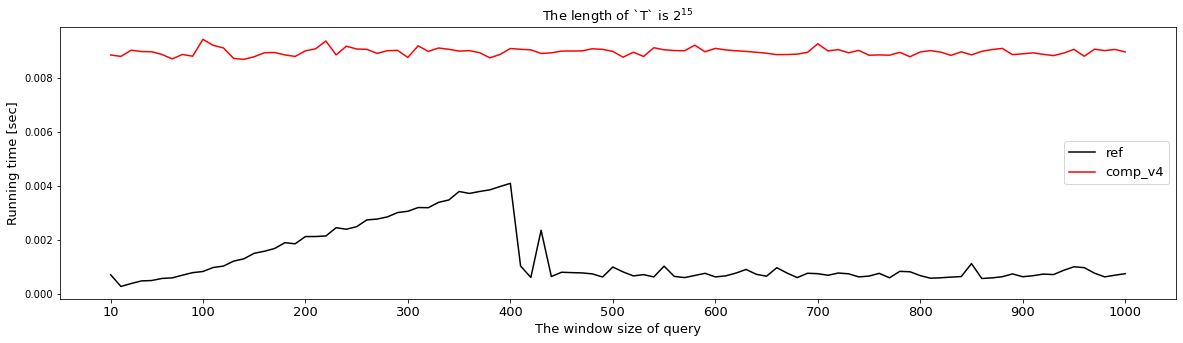

In [127]:
plt.figure(figsize=(20, 5))
plt.title('The length of `T` is $2^{15}$', fontsize=13)

plt.plot(running_time[:, 0], color='k', label='ref')
#plt.plot(running_time[:, 1], color='orange', label='comp_v1')
#plt.plot(running_time[:, 2], color='darkgreen', label='comp_v2')
#plt.plot(running_time[:, 3], color='cyan', label='comp_v3')
plt.plot(running_time[:, 4], color='r', label='comp_v4')

plt.xticks(ticks=IDX, labels=m_values_label, fontsize=13)
plt.xlabel('The window size of query', fontsize=13)
plt.ylabel('Running time [sec]', fontsize=13)

plt.legend(ncols=1, fontsize=13)
plt.show()

## Let's conider different length for `T`

In [129]:
n_T = np.power(2, range(11, 21))

In [130]:
comp_func = sliding_dot_product_v4
ref_func = core.sliding_dot_product

seed = 0
np.random.seed(seed)

out = {}
m_values = range(10, 1000 + 10, 10)
for p in range(10, 21):
    n = 2 ** p
    T = np.random.rand(n)
    
    running_time = np.zeros((len(m_values), 2))         
    for i, m in enumerate(m_values):
        Q = T[:m]

        # ref
        t1 = time.time()
        ref = ref_func(Q, T)
        t2 = time.time()
        running_time[i, 0] = t2 - t1

        # comp
        t1 = time.time()
        comp = comp_func(Q, T)
        t2 = time.time()
        running_time[i, 1] = t2 - t1

        np.testing.assert_almost_equal(ref, comp)
    
    out[p] = running_time

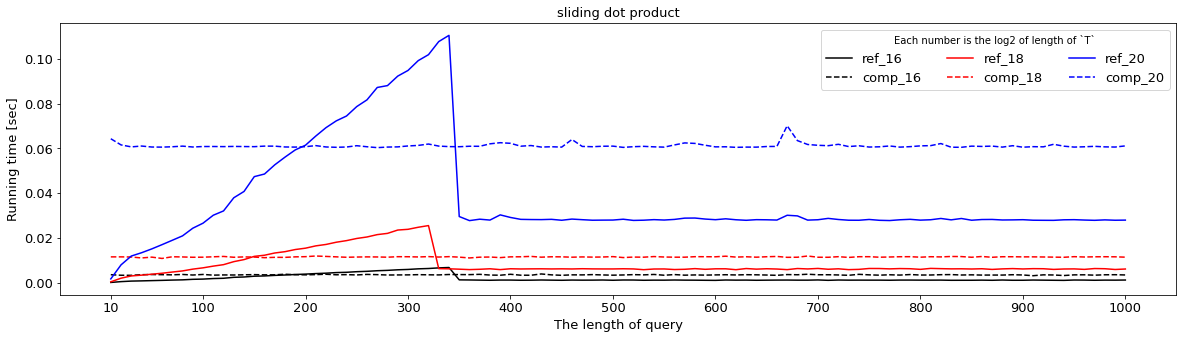

In [132]:
# let's plot the figures for n = 2 ** p, with p in {16, 18, 20}

colors=['k', 'r', 'b', 'orange', 'gray', 'darkgreen', 'darkgreen', 'cyan', 'gray', 'purple', 'brown']

m_values_labels = np.arange(0, 1000 + 100, 100)
m_values_labels[0] = 10
m_values_ticks = np.flatnonzero(np.isin(m_values, m_values_labels))

plt.figure(figsize=(20, 5))
plt.title('sliding dot product', fontsize=13)
for i, p in enumerate([16, 18, 20]): 
    plt.plot(out[p][:, 0], c=colors[i], label=f'ref_{p}')
    plt.plot(out[p][:, 1], c=colors[i], linestyle='--', label=f'comp_{p}')


plt.xticks(ticks=m_values_ticks, labels=m_values_labels, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel('The length of query', fontsize=13)
plt.ylabel('Running time [sec]', fontsize=13)
plt.legend(title='Each number is the log2 of length of `T`', ncols=3, fontsize=13)
plt.show()